In [1]:
!hostname

node03.pri.mars.alces.network


In [2]:
#Current row in  voice analysis : 124886

In [1]:
import glob
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow

In [2]:
types = { "time" : "float64",
                'file_tag' : "string",
                'F1_freq': "float64",
                'F1_bw': "float64",
                'F2_freq': "float64",
                'F2_bw': "float64",
                'F3_freq': "float64",
                'F3_bw': "float64",
                'F4_freq': "float64",
                'F4_bw': "float64",
                'F5_freq': "float64",
                'F5_bw': "float64",
                'f0': "float64",
                'centroid': "float64",
                'rms': "float64",
                'talking': "float64",
                'harmonicity': "float64",
        }

In [5]:
dfs = []

for file in glob.glob("audio_analysis_ts/prolific/*.csv"):
    if os.stat(file).st_size == 0:
        print("File is empty, skipping:", file)
        continue
    file_parts = file.split("/")[-1].split("-")
    sid = file_parts[6]
    dyad = file_parts[9]
    participant = file_parts[11]
    manipulated = file_parts[14][:3]

    if "dry" in manipulated:
        manipulated = False
    elif "wet" in manipulated:
        manipulated = True
    else:
        print("manipulated error in file:", file)
        manipulated = "error"
    
    df = pd.read_csv(file, index_col=0)
    df.index.name = 'time'
    df = df.reset_index()
    df = df.astype(types)
    df  = pl.from_pandas(df)

    df = df.with_columns([
    pl.lit(sid).alias("sid"),
    pl.lit(dyad).alias("dyad"),
    pl.lit(participant).alias("participant"),
    pl.lit(manipulated).alias("manipulated")
    ])
    
    dfs.append(df)

In [6]:
all_audio_df = pl.concat(dfs)
all_audio_df.head()

time,F1_freq,F1_bw,F2_freq,F2_bw,F3_freq,F3_bw,F4_freq,F4_bw,F5_freq,F5_bw,f0,centroid,rms,talking,harmonicity,file_tag,sid,dyad,participant,manipulated
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,bool
0.0,638.31,827.01,1566.09,809.02,2873.61,1344.49,3590.27,915.21,5258.63,1884.26,null,6624.913442,-66.335082,1.0,null,"""i-379698a0e74b40f4d6548b29c04c…","""mkreal_meeting_experiment_prol…","""p1p7""","""p1""",true
0.002,638.31,827.01,1566.09,809.02,2873.61,1344.49,3590.27,915.21,5258.63,1884.26,null,6624.913442,-66.335082,0.0,null,"""i-379698a0e74b40f4d6548b29c04c…","""mkreal_meeting_experiment_prol…","""p1p7""","""p1""",true
0.004,638.31,827.01,1566.09,809.02,2873.61,1344.49,3590.27,915.21,5258.63,1884.26,null,6624.913442,-66.335082,0.0,null,"""i-379698a0e74b40f4d6548b29c04c…","""mkreal_meeting_experiment_prol…","""p1p7""","""p1""",true
0.006,638.31,827.01,1566.09,809.02,2873.61,1344.49,3590.27,915.21,5258.63,1884.26,null,6624.913442,-66.335082,0.0,null,"""i-379698a0e74b40f4d6548b29c04c…","""mkreal_meeting_experiment_prol…","""p1p7""","""p1""",true
0.008,638.31,827.01,1566.09,809.02,2873.61,1344.49,3590.27,915.21,5258.63,1884.26,null,6624.913442,-66.335082,0.0,null,"""i-379698a0e74b40f4d6548b29c04c…","""mkreal_meeting_experiment_prol…","""p1p7""","""p1""",true


In [7]:
all_audio_df = all_audio_df.with_columns([
    (pl.col("sid") + pl.col("participant")).alias("user_id")
])

In [8]:
#import behavioral data
all_data_df = pd.read_csv("behavioral_data/all_data_df.csv")

all_data_df["sid"]      = [x.replace(":", "") for x in all_data_df["sid"].values]
all_data_df["user_id"]  = [x.replace(":", "") for x in all_data_df["user_id"].values]
all_data_df["other_id"] = [x.replace(":", "") for x in all_data_df["other_id"].values]

all_data_df.head()

all_data_df = pl.from_pandas(all_data_df)


In [9]:
all_data_df = all_data_df.join(all_audio_df, on=["sid", "dyad", "user_id"], how="left")
all_data_df.head()

Unnamed: 0,index,sid,dyad,user_id,other_id,participant_condition,other_condition,question_content,measure,time,F1_freq,F1_bw,F2_freq,F2_bw,F3_freq,F3_bw,F4_freq,F4_bw,F5_freq,F5_bw,f0,centroid,rms,talking,harmonicity,file_tag,participant,manipulated
i64,i64,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,bool
0,0,"""mkprolific_participant_real_21""","""p1p5""","""mkprolific_participant_real_21…","""mkprolific_participant_real_21…","""U""","""U""","""liked""",4.0,0.0,432.45,44.23,1948.71,695.22,2854.7,710.74,4176.13,1186.41,4410.32,2203.84,null,6054.227676,-62.67943,1.0,null,"""i-ac91e8ea43c8e92638a060a4e684…","""p1""",false
0,0,"""mkprolific_participant_real_21""","""p1p5""","""mkprolific_participant_real_21…","""mkprolific_participant_real_21…","""U""","""U""","""liked""",4.0,0.002,432.45,44.23,1948.71,695.22,2854.7,710.74,4176.13,1186.41,4410.32,2203.84,null,6054.227676,-62.67943,1.0,null,"""i-ac91e8ea43c8e92638a060a4e684…","""p1""",false
0,0,"""mkprolific_participant_real_21""","""p1p5""","""mkprolific_participant_real_21…","""mkprolific_participant_real_21…","""U""","""U""","""liked""",4.0,0.004,432.45,44.23,1948.71,695.22,2854.7,710.74,4176.13,1186.41,4410.32,2203.84,null,6054.227676,-62.67943,1.0,null,"""i-ac91e8ea43c8e92638a060a4e684…","""p1""",false
0,0,"""mkprolific_participant_real_21""","""p1p5""","""mkprolific_participant_real_21…","""mkprolific_participant_real_21…","""U""","""U""","""liked""",4.0,0.006,432.45,44.23,1948.71,695.22,2854.7,710.74,4176.13,1186.41,4410.32,2203.84,null,6054.227676,-62.67943,1.0,null,"""i-ac91e8ea43c8e92638a060a4e684…","""p1""",false
0,0,"""mkprolific_participant_real_21""","""p1p5""","""mkprolific_participant_real_21…","""mkprolific_participant_real_21…","""U""","""U""","""liked""",4.0,0.008,432.45,44.23,1948.71,695.22,2854.7,710.74,4176.13,1186.41,4410.32,2203.84,null,6054.227676,-62.67943,1.0,null,"""i-ac91e8ea43c8e92638a060a4e684…","""p1""",false


In [10]:
#check data_completion
all_data_df.group_by(["sid", "participant", "dyad"]).mean()


sid,participant,dyad,Unnamed: 0,index,user_id,other_id,participant_condition,other_condition,question_content,measure,time,F1_freq,F1_bw,F2_freq,F2_bw,F3_freq,F3_bw,F4_freq,F4_bw,F5_freq,F5_bw,f0,centroid,rms,talking,harmonicity,file_tag,manipulated
str,str,str,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
"""mkprolific_participant_real_32""","""p4""","""p4p7""",393.5,393.5,null,null,null,null,null,6.25,124.8795,654.605645,657.402779,1805.826872,658.506029,2826.730687,844.742766,3922.640155,862.889794,5002.905403,1140.633493,198.361876,5228.004755,-62.871538,0.338075,0.264742,null,0.500022
"""mkprolific_participant_real_31""","""p3""","""p3p7""",249.5,249.5,null,null,null,null,null,5.5,124.447501,801.23794,624.264966,1818.653089,937.538531,2805.643335,932.824472,3832.11232,1018.186541,4922.491743,1002.464448,231.90289,5405.307305,-67.119552,0.288027,0.146325,null,0.500042
"""mkreal_meeting_experiment_prol…","""p6""","""p3p6""",753.5,753.5,null,null,null,null,null,4.5,102.652397,879.918143,681.90128,1743.982882,310.228183,2731.261195,494.569229,3905.416742,557.513814,4951.996118,875.569536,154.35078,3189.341736,-47.279198,0.922251,0.163091,null,0.497584
"""mkreal_meeting_experiment_prol…","""p7""","""p2p7""",457.5,457.5,null,null,null,null,null,6.5,124.922,748.031397,526.178383,1745.44965,809.878837,2796.707414,834.474559,3863.553439,1044.628309,4934.775757,999.21376,198.842169,4222.152297,-56.129498,0.392582,0.155906,null,0.49998
"""mkprolific_participant_real_32""","""p5""","""p3p5""",349.5,349.5,null,null,null,null,null,4.25,124.864,771.957317,511.645883,1836.949875,455.906607,2742.158419,521.080233,3744.267447,711.8711,4868.425203,1195.758151,202.301193,2931.771116,-46.581312,0.602795,0.356573,null,0.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""mkreal_meeting_experiment_prol…","""p7""","""p4p7""",665.5,665.5,null,null,null,null,null,6.25,124.9115,824.517007,441.53709,1784.966171,1070.883817,2694.384567,570.821394,3766.755604,900.831197,4866.05117,1013.097308,212.485255,4563.466079,-48.93731,0.315209,0.131747,null,0.500022
"""mkreal_meeting_experiment_prol…","""p5""","""p4p5""",505.5,505.5,null,null,null,null,null,5.75,124.959,754.197154,471.101757,1875.678135,577.0819,2978.378429,738.486257,4019.644834,991.547381,4951.056879,1188.052022,183.785916,4882.519728,-61.633457,0.278001,0.070801,null,0.5
"""mkprolific_participant_real_22""","""p7""","""p4p7""",193.5,193.5,null,null,null,null,null,6.0,124.911518,742.965084,888.23296,1835.442351,690.226282,2872.606659,912.080755,3938.030304,853.023352,4859.414495,1013.848111,153.720441,5651.30696,-51.497434,0.490671,0.210815,null,0.49981


In [11]:
all_data_df.write_csv("audio_compiled_data/server_audio_analysis_all_data_df.csv")
all_data_df.head()

Unnamed: 0,index,sid,dyad,user_id,other_id,participant_condition,other_condition,question_content,measure,time,F1_freq,F1_bw,F2_freq,F2_bw,F3_freq,F3_bw,F4_freq,F4_bw,F5_freq,F5_bw,f0,centroid,rms,talking,harmonicity,file_tag,participant,manipulated
i64,i64,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,bool
0,0,"""mkprolific_participant_real_21""","""p1p5""","""mkprolific_participant_real_21…","""mkprolific_participant_real_21…","""U""","""U""","""liked""",4.0,0.0,432.45,44.23,1948.71,695.22,2854.7,710.74,4176.13,1186.41,4410.32,2203.84,null,6054.227676,-62.67943,1.0,null,"""i-ac91e8ea43c8e92638a060a4e684…","""p1""",false
0,0,"""mkprolific_participant_real_21""","""p1p5""","""mkprolific_participant_real_21…","""mkprolific_participant_real_21…","""U""","""U""","""liked""",4.0,0.002,432.45,44.23,1948.71,695.22,2854.7,710.74,4176.13,1186.41,4410.32,2203.84,null,6054.227676,-62.67943,1.0,null,"""i-ac91e8ea43c8e92638a060a4e684…","""p1""",false
0,0,"""mkprolific_participant_real_21""","""p1p5""","""mkprolific_participant_real_21…","""mkprolific_participant_real_21…","""U""","""U""","""liked""",4.0,0.004,432.45,44.23,1948.71,695.22,2854.7,710.74,4176.13,1186.41,4410.32,2203.84,null,6054.227676,-62.67943,1.0,null,"""i-ac91e8ea43c8e92638a060a4e684…","""p1""",false
0,0,"""mkprolific_participant_real_21""","""p1p5""","""mkprolific_participant_real_21…","""mkprolific_participant_real_21…","""U""","""U""","""liked""",4.0,0.006,432.45,44.23,1948.71,695.22,2854.7,710.74,4176.13,1186.41,4410.32,2203.84,null,6054.227676,-62.67943,1.0,null,"""i-ac91e8ea43c8e92638a060a4e684…","""p1""",false
0,0,"""mkprolific_participant_real_21""","""p1p5""","""mkprolific_participant_real_21…","""mkprolific_participant_real_21…","""U""","""U""","""liked""",4.0,0.008,432.45,44.23,1948.71,695.22,2854.7,710.74,4176.13,1186.41,4410.32,2203.84,null,6054.227676,-62.67943,1.0,null,"""i-ac91e8ea43c8e92638a060a4e684…","""p1""",false


# PITCH Analysis

In [3]:
cols = ["sid", "dyad", "user_id", "other_id","participant_condition", "other_condition", "f0", "harmonicity", "talking"]

all_data_df = pl.read_csv("audio_compiled_data/server_audio_analysis_all_data_df.csv", columns=cols)

In [8]:
df_analysis = all_data_df.filter(pl.col("talking") == 1)

# Group by the specified columns and calculate the mean of the numeric columns
df_analysis = df_analysis.group_by(["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition"]).agg([
    pl.mean("f0").alias("f0_mean"),
    pl.std("f0").alias("f0_std")
]).to_pandas()

df_analysis.to_csv("audio_compiled_data/collapsed_pitch_from_server.csv.csv")

## Mean pitch

/tmp/ipykernel_27115/1557340207.py:1: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot( x="participant_condition", y="f0_mean", units="user_id"
/tmp/ipykernel_27115/1557340207.py:1: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  g = sns.catplot( x="participant_condition", y="f0_mean", units="user_id"


<Axes: xlabel='participant_condition', ylabel='f0_mean'>

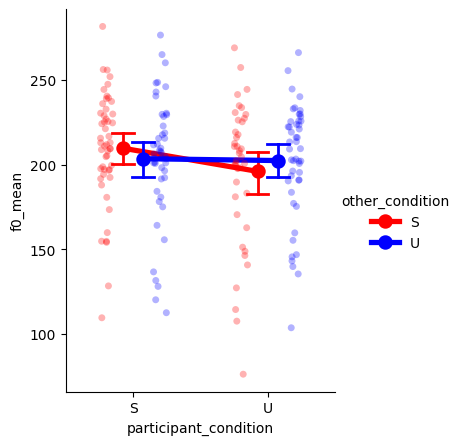

In [9]:
g = sns.catplot( x="participant_condition", y="f0_mean", units="user_id"
                    , height=4.6
                    , aspect=0.8
                    , data=df_analysis
                    , kind="point"
                    , capsize=.16
                    , hue="other_condition"
                    , legend=True
                    , scale=1.4
                    , dodge= 0.15
                    , errwidth=2
                    , order=["S", "U"]
                    , hue_order=["S", "U"]
                    , palette= sns.color_palette(["red", "blue"])
            )

# Add individual measure points
sns.stripplot(x="participant_condition", y="f0_mean"
                , data=df_analysis
                , hue="other_condition", dodge=0.15, size=5, alpha=0.3
                , legend=False
                , order=["S", "U"]
                , hue_order=["S", "U"]
                , palette= sns.color_palette(["red", "blue"])
                )    
    
#g.set(ylim=(0, 1.7))

#plt.savefig("plots/facial_mimicry_legend.pdf", bbox_inches='tight')
#g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
#plt.savefig("plots/facial_mimicry.pdf", bbox_inches='tight')

## Pitch STD

/tmp/ipykernel_27115/2645729963.py:2: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot( x="participant_condition", y="f0_std", units="user_id"


<Axes: xlabel='participant_condition', ylabel='f0_std'>

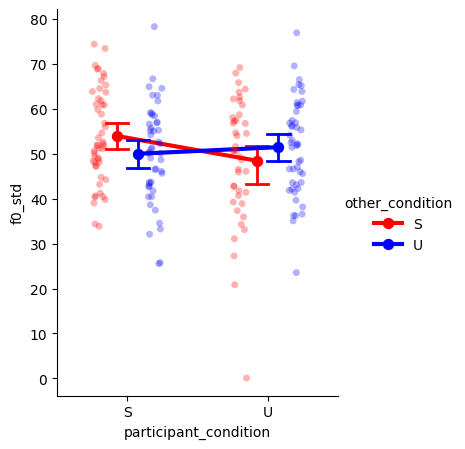

In [10]:
## # STANDARD DEVIATION
g = sns.catplot( x="participant_condition", y="f0_std", units="user_id"
                    , height=4.6
                    , aspect=0.8
                    , data=df_analysis
                    , kind="point"
                    , capsize=.16
                    , hue="other_condition"
                    , legend=True
                    , scale=1.1
                    , dodge= 0.15
                    , err_kws={'linewidth': 2}
                    , order=["S", "U"]
                    , hue_order=["S", "U"]
                    , palette= sns.color_palette(["red", "blue"])
            )

# Add individual measure points
sns.stripplot(x="participant_condition", y="f0_std"
                , data=df_analysis
                , hue="other_condition", dodge=0.15, size=5, alpha=0.3
                , legend=False
                , order=["S", "U"]
                , hue_order=["S", "U"]
                , palette= sns.color_palette(["red", "blue"])
                )    
    
#g.set(ylim=(0, 1.7))

#plt.savefig("plots/facial_mimicry_legend.pdf", bbox_inches='tight')
#g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
#plt.savefig("plots/facial_mimicry.pdf", bbox_inches='tight')

# RMS Analysis

In [29]:
cols = ["sid", "dyad", "user_id", "other_id","participant_condition", "other_condition", "rms", "harmonicity", "talking"]

all_data_df = pl.read_csv("audio_compiled_data/server_audio_analysis_all_data_df.csv", columns=cols)

In [30]:
df_analysis = all_data_df.filter(pl.col("talking") == 1)

# Group by the specified columns and calculate the mean of the numeric columns
df_analysis = df_analysis.group_by(["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition"]).agg([
    pl.mean("rms").alias("rms_mean"),
    pl.std("rms").alias("rms_std")
]).to_pandas()

#df_analysis.to_csv("audio_compiled_data/collapsed_pitch_from_server.csv.csv")

## Mean RMS

/tmp/ipykernel_27115/2187781451.py:3: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot( x="participant_condition", y="rms_mean", units="user_id"
/tmp/ipykernel_27115/2187781451.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  g = sns.catplot( x="participant_condition", y="rms_mean", units="user_id"


<Axes: xlabel='participant_condition', ylabel='rms_mean'>

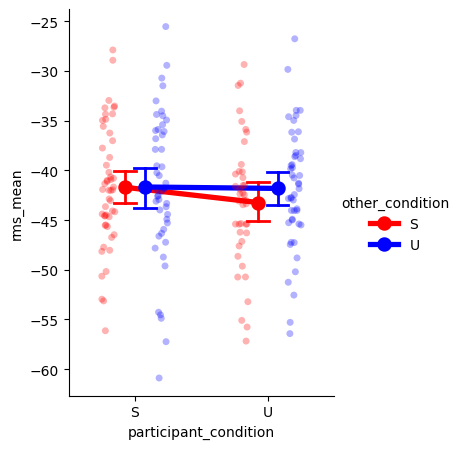

In [33]:
df = df_analysis.loc[df_analysis["rms_mean"] > -75]

g = sns.catplot( x="participant_condition", y="rms_mean", units="user_id"
                    , height=4.6
                    , aspect=0.8
                    , data=df
                    , kind="point"
                    , capsize=.16
                    , hue="other_condition"
                    , legend=True
                    , scale=1.4
                    , dodge= 0.15
                    , errwidth=2
                    , order=["S", "U"]
                    , hue_order=["S", "U"]
                    , palette= sns.color_palette(["red", "blue"])
            )

# Add individual measure points
sns.stripplot(x="participant_condition", y="rms_mean"
                , data=df
                , hue="other_condition", dodge=0.15, size=5, alpha=0.3
                , legend=False
                , order=["S", "U"]
                , hue_order=["S", "U"]
                , palette= sns.color_palette(["red", "blue"])
                )    
    
#g.set(ylim=(0, 1.7))

#plt.savefig("plots/facial_mimicry_legend.pdf", bbox_inches='tight')
#g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
#plt.savefig("plots/facial_mimicry.pdf", bbox_inches='tight')

## RMS STD

/tmp/ipykernel_27115/945360737.py:2: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot( x="participant_condition", y="rms_std", units="user_id"


<Axes: xlabel='participant_condition', ylabel='rms_std'>

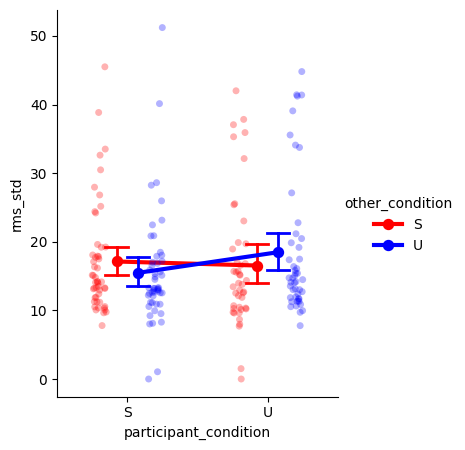

In [32]:
## # STANDARD DEVIATION
g = sns.catplot( x="participant_condition", y="rms_std", units="user_id"
                    , height=4.6
                    , aspect=0.8
                    , data=df_analysis
                    , kind="point"
                    , capsize=.16
                    , hue="other_condition"
                    , legend=True
                    , scale=1.1
                    , dodge= 0.15
                    , err_kws={'linewidth': 2}
                    , order=["S", "U"]
                    , hue_order=["S", "U"]
                    , palette= sns.color_palette(["red", "blue"])
            )

# Add individual measure points
sns.stripplot(x="participant_condition", y="rms_std"
                , data=df_analysis
                , hue="other_condition", dodge=0.15, size=5, alpha=0.3
                , legend=False
                , order=["S", "U"]
                , hue_order=["S", "U"]
                , palette= sns.color_palette(["red", "blue"])
                )    
    
#g.set(ylim=(0, 1.7))

#plt.savefig("plots/facial_mimicry_legend.pdf", bbox_inches='tight')
#g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
#plt.savefig("plots/facial_mimicry.pdf", bbox_inches='tight')

# Formant freqs

In [ ]:
cols = ["sid", "dyad", "user_id", "other_id","participant_condition"
        , "other_condition", "F1_freq", "F2_freq", "F3_freq", "F4_freq", "F5_freq", "harmonicity", "talking"
       ]

all_data_df = pl.read_csv("audio_compiled_data/server_audio_analysis_all_data_df.csv", columns=cols)

In [ ]:
df_analysis = all_data_df.filter(pl.col("talking") == 1)

# Get all numeric columns
numeric_cols = df_analysis.select(pl.col("*").exclude(["sid", "dyad", "user_id", "participant_condition", "other_condition"])).columns

# Group by the specified columns and calculate the mean and std for all numeric columns
agg_list = []
for col in numeric_cols:
    agg_list.append(pl.mean(col).alias(f"{col}_mean"))
    agg_list.append(pl.std(col).alias(f"{col}_std"))

df_analysis = df_analysis.group_by(["sid", "dyad", "user_id", "participant_condition", "other_condition"]).agg(agg_list)

# Convert to pandas DataFrame if needed
df_analysis = df_analysis.to_pandas()

df_analysis.head()

df_analysis.to_csv("audio_compiled_data/formants.csv")


/tmp/ipykernel_61603/3888601398.py:2: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot( x="participant_condition", y=formant, units="user_id"
/tmp/ipykernel_61603/3888601398.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  g = sns.catplot( x="participant_condition", y=formant, units="user_id"
/tmp/ipykernel_61603/3888601398.py:2: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot( x="participant_condition", y=formant, units="user_id"
/tmp/ipykernel_61603/3888601398.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be remov

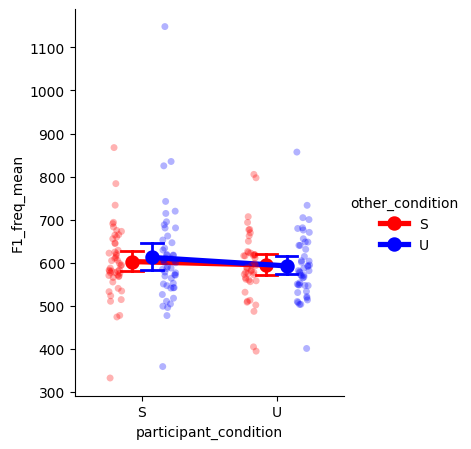

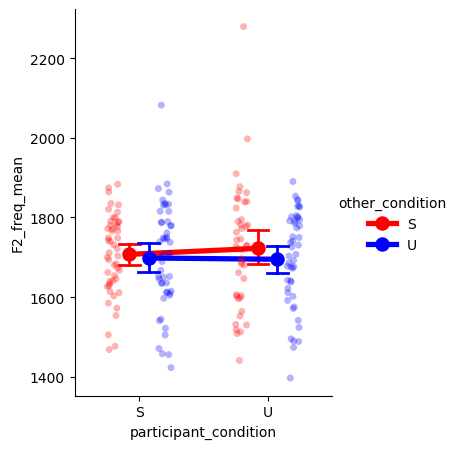

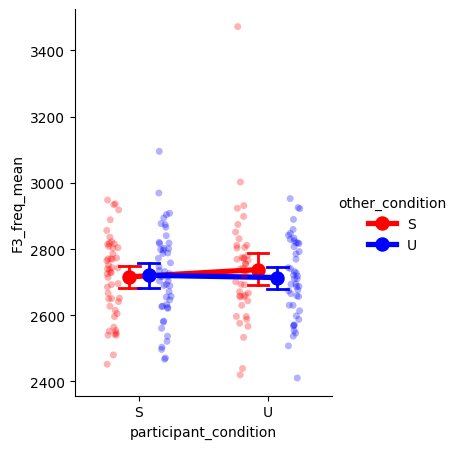

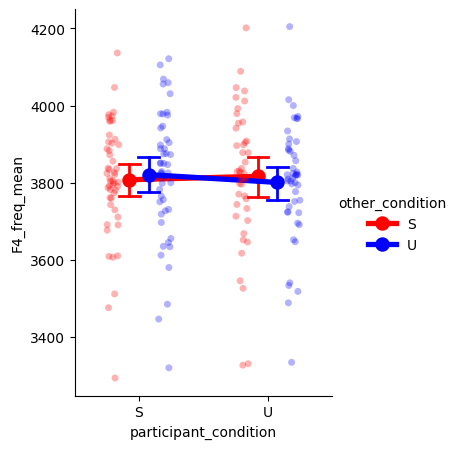

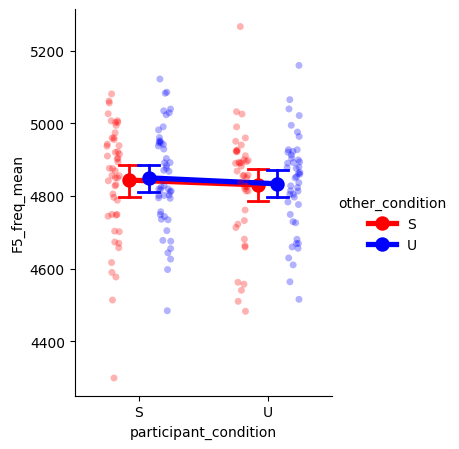

In [19]:
for formant in ["F1_freq_mean", "F2_freq_mean", "F3_freq_mean", "F4_freq_mean", "F5_freq_mean"]:
        g = sns.catplot( x="participant_condition", y=formant, units="user_id"
                        , height=4.6
                        , aspect=0.8
                        , data=df_analysis
                        , kind="point"
                        , capsize=.16
                        , hue="other_condition"
                        , legend=True
                        , scale=1.4
                        , dodge= 0.15
                        , errwidth=2
                        , order=["S", "U"]
                        , hue_order=["S", "U"]
                        , palette= sns.color_palette(["red", "blue"])
                )

        # Add individual measure points
        sns.stripplot(x="participant_condition"
                        , y=formant
                        , data=df_analysis
                        , hue="other_condition", dodge=0.15, size=5, alpha=0.3
                        , legend=False
                        , order=["S", "U"]
                        , hue_order=["S", "U"]
                        , palette= sns.color_palette(["red", "blue"])
                        )
        
        #g.set(ylim=(0, 1.7))

        #plt.savefig("plots/facial_mimicry_legend.pdf", bbox_inches='tight')
        #g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
        #plt.savefig("plots/facial_mimicry.pdf", bbox_inches='tight')

In [ ]:
for formant in ["F1_freq_std", "F2_freq_std", "F3_freq_std", "F4_freq_std", "F5_freq_std"]:
        g = sns.catplot( x="participant_condition", y=formant, units="user_id"
                        , height=4.6
                        , aspect=0.8
                        , data=df_analysis
                        , kind="point"
                        , capsize=.16
                        , hue="other_condition"
                        , legend=True
                        , scale=1.4
                        , dodge= 0.15
                        , errwidth=2
                        , order=["S", "U"]
                        , hue_order=["S", "U"]
                        , palette= sns.color_palette(["red", "blue"])
                )

        # Add individual measure points
        sns.stripplot(x="participant_condition"
                        , y=formant
                        , data=df_analysis
                        , hue="other_condition", dodge=0.15, size=5, alpha=0.3
                        , legend=False
                        , order=["S", "U"]
                        , hue_order=["S", "U"]
                        , palette= sns.color_palette(["red", "blue"])
                        )
        
        #g.set(ylim=(0, 1.7))

        #plt.savefig("plots/facial_mimicry_legend.pdf", bbox_inches='tight')
        #g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
        #plt.savefig("plots/facial_mimicry.pdf", bbox_inches='tight')

# Formants

In [21]:
cols = ["sid", "dyad", "user_id", "other_id","participant_condition"
        , "other_condition", "F1_bw", "F2_bw", "F3_bw", "F4_bw", "F5_bw", "harmonicity", "talking"
       ]

all_data_df = pl.read_csv("audio_compiled_data/server_audio_analysis_all_data_df.csv", columns=cols)

In [22]:
df_analysis = all_data_df.filter(pl.col("talking") == 1)

# Get all numeric columns
numeric_cols = df_analysis.select(pl.col("*").exclude(["sid", "dyad", "user_id", "participant_condition", "other_condition"])).columns

# Group by the specified columns and calculate the mean and std for all numeric columns
agg_list = []
for col in numeric_cols:
    agg_list.append(pl.mean(col).alias(f"{col}_mean"))
    agg_list.append(pl.std(col).alias(f"{col}_std"))

df_analysis = df_analysis.group_by(["sid", "dyad", "user_id", "participant_condition", "other_condition"]).agg(agg_list)

# Convert to pandas DataFrame if needed
df_analysis = df_analysis.to_pandas()

df_analysis.head()

,sid,dyad,user_id,participant_condition,other_condition,other_id_mean,other_id_std,F1_bw_mean,F1_bw_std,F2_bw_mean,...,F3_bw_mean,F3_bw_std,F4_bw_mean,F4_bw_std,F5_bw_mean,F5_bw_std,talking_mean,talking_std,harmonicity_mean,harmonicity_std
0,mkreal_meeting_experiment_prolific2,p2p8,mkreal_meeting_experiment_prolific2p8,U,S,None,None,467.662680,561.846901,644.496797,...,972.445264,871.102433,1012.892241,1015.051345,1042.703471,824.763073,1.0,0.0,0.200965,0.392555
1,mkreal_meeting_experiment_prolific6,p3p7,mkreal_meeting_experiment_prolific6p7,U,S,None,None,410.042632,478.579827,469.488219,...,468.084967,534.435617,899.140674,892.874967,1228.465732,889.014903,1.0,0.0,0.503704,0.495446
2,mkprolific_participant_real_31,p2p7,mkprolific_participant_real_31p7,U,U,None,None,501.728852,513.871813,536.664334,...,605.159576,675.459410,755.059375,770.992082,984.973732,906.765197,1.0,0.0,0.409401,0.485295
3,mkprolific_participant_real_21,p2p5,mkprolific_participant_real_21p2,S,S,None,None,273.756402,384.625711,510.642824,...,621.396770,684.198480,1013.680648,936.679229,1241.737685,831.964552,1.0,0.0,0.205581,0.398057
4,mkprolific_participant_real_22,p2p7,mkprolific_participant_real_22p7,U,U,None,None,559.846734,527.806709,369.933281,...,782.676020,652.453423,687.175308,668.099249,1023.531799,814.409589,1.0,0.0,0.308913,0.453268


/tmp/ipykernel_61603/328626271.py:2: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot( x="participant_condition", y=formant, units="user_id"
/tmp/ipykernel_61603/328626271.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  g = sns.catplot( x="participant_condition", y=formant, units="user_id"
/tmp/ipykernel_61603/328626271.py:2: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot( x="participant_condition", y=formant, units="user_id"
/tmp/ipykernel_61603/328626271.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed i

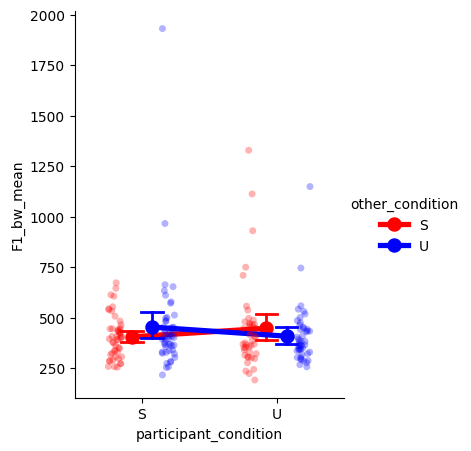

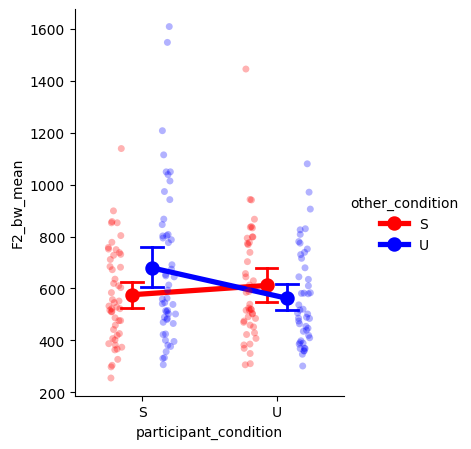

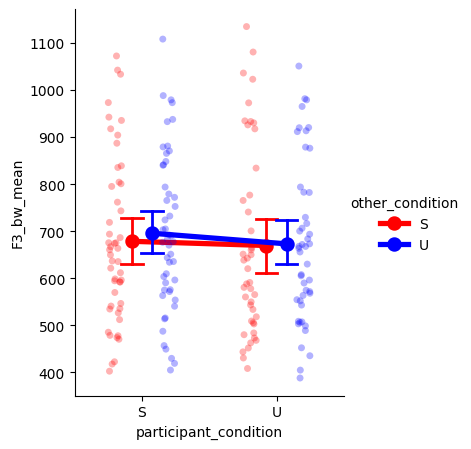

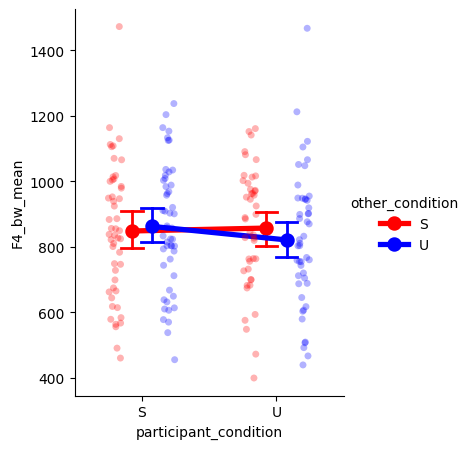

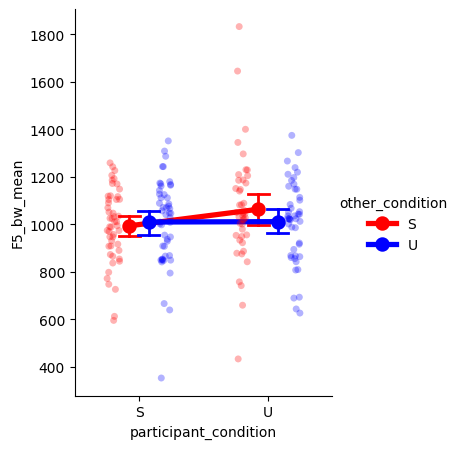

In [23]:
#Mean of formants

for formant in ["F1_bw_mean", "F2_bw_mean", "F3_bw_mean", "F4_bw_mean", "F5_bw_mean"]:
        g = sns.catplot( x="participant_condition", y=formant, units="user_id"
                        , height=4.6
                        , aspect=0.8
                        , data=df_analysis
                        , kind="point"
                        , capsize=.16
                        , hue="other_condition"
                        , legend=True
                        , scale=1.4
                        , dodge= 0.15
                        , errwidth=2
                        , order=["S", "U"]
                        , hue_order=["S", "U"]
                        , palette= sns.color_palette(["red", "blue"])
                )

        # Add individual measure points
        sns.stripplot(x="participant_condition"
                        , y=formant
                        , data=df_analysis
                        , hue="other_condition", dodge=0.15, size=5, alpha=0.3
                        , legend=False
                        , order=["S", "U"]
                        , hue_order=["S", "U"]
                        , palette= sns.color_palette(["red", "blue"])
                        )
        
        #g.set(ylim=(0, 1.7))

        #plt.savefig("plots/facial_mimicry_legend.pdf", bbox_inches='tight')
        #g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
        #plt.savefig("plots/facial_mimicry.pdf", bbox_inches='tight')

/tmp/ipykernel_61603/442753832.py:2: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot( x="participant_condition", y=formant, units="user_id"
/tmp/ipykernel_61603/442753832.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  g = sns.catplot( x="participant_condition", y=formant, units="user_id"
/tmp/ipykernel_61603/442753832.py:2: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot( x="participant_condition", y=formant, units="user_id"
/tmp/ipykernel_61603/442753832.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed i

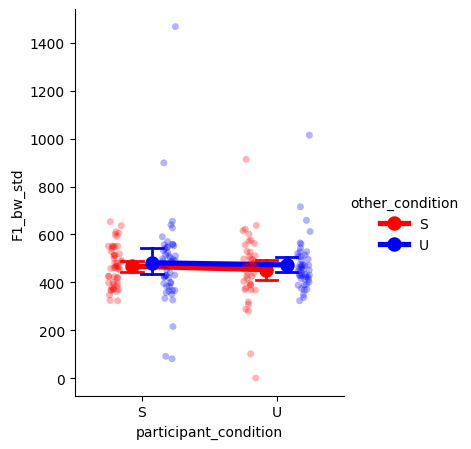

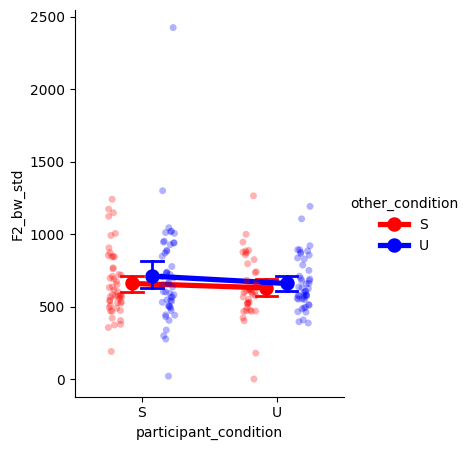

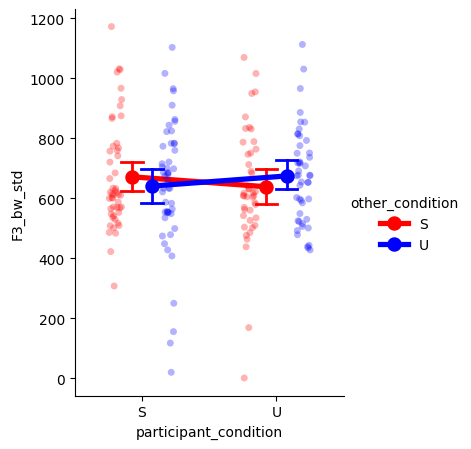

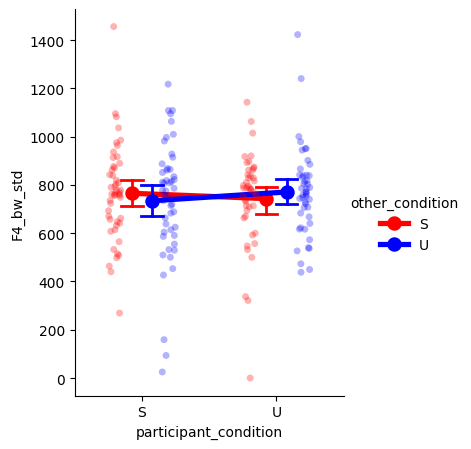

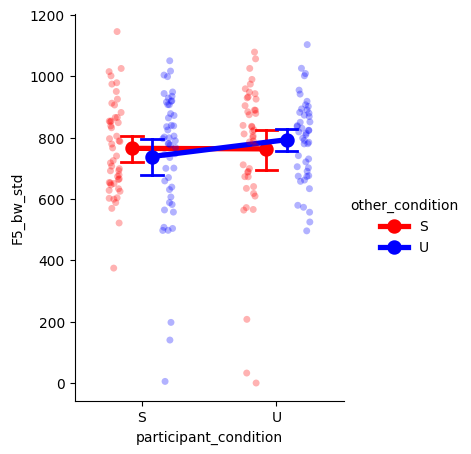

In [24]:
#STD of formants
for formant in ["F1_bw_std", "F2_bw_std", "F3_bw_std", "F4_bw_std", "F5_bw_std"]:
        g = sns.catplot( x="participant_condition", y=formant, units="user_id"
                        , height=4.6
                        , aspect=0.8
                        , data=df_analysis
                        , kind="point"
                        , capsize=.16
                        , hue="other_condition"
                        , legend=True
                        , scale=1.4
                        , dodge= 0.15
                        , errwidth=2
                        , order=["S", "U"]
                        , hue_order=["S", "U"]
                        , palette= sns.color_palette(["red", "blue"])
                )

        # Add individual measure points
        sns.stripplot(x="participant_condition"
                        , y=formant
                        , data=df_analysis
                        , hue="other_condition", dodge=0.15, size=5, alpha=0.3
                        , legend=False
                        , order=["S", "U"]
                        , hue_order=["S", "U"]
                        , palette= sns.color_palette(["red", "blue"])
                        )
        
        #g.set(ylim=(0, 1.7))

        #plt.savefig("plots/facial_mimicry_legend.pdf", bbox_inches='tight')
        #g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
        #plt.savefig("plots/facial_mimicry.pdf", bbox_inches='tight')

# Correlations

In [21]:
cols = ["sid", "dyad", "user_id", "other_id","participant_condition"
        , "other_condition", "f0", "harmonicity", "talking"
        , "question_content", "measure"
       ]

all_data_df = pl.read_csv("audio_compiled_data/server_audio_analysis_all_data_df.csv", columns=cols)

In [22]:
df_analysis = all_data_df.filter(pl.col("talking") == 1)

idx= ["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition", "question_content"]

# Get all numeric columns
numeric_cols = df_analysis.select(pl.col("*").exclude(idx)).columns

# Group by the specified columns and calculate the mean and std for all numeric columns
agg_list = []
for col in numeric_cols:
    agg_list.append(pl.mean(col).alias(f"{col}_mean"))
    agg_list.append(pl.std(col).alias(f"{col}_std"))

df_analysis = df_analysis.group_by(idx).agg(agg_list)

# Convert to pandas DataFrame if needed
df_analysis = df_analysis.to_pandas()

df_analysis.head()


,sid,dyad,user_id,other_id,participant_condition,other_condition,question_content,measure_mean,measure_std,f0_mean,f0_std,talking_mean,talking_std,harmonicity_mean,harmonicity_std
0,mkreal_meeting_experiment_prolific6,p2p8,mkreal_meeting_experiment_prolific6p2,mkreal_meeting_experiment_prolific6p8,S,U,conversation_quality,7.0,0.0,198.183840,32.077330,1.0,0.0,0.513238,0.495837
1,mkprolific_participant_real_21,p2p5,mkprolific_participant_real_21p2,mkprolific_participant_real_21p5,S,S,liked,7.0,0.0,235.971666,69.626258,1.0,0.0,0.205581,0.398061
2,mkreal_meeting_experiment_prolific2,p4p8,mkreal_meeting_experiment_prolific2p4,mkreal_meeting_experiment_prolific2p8,S,S,conversation_quality,7.0,0.0,197.579350,40.454775,1.0,0.0,0.424241,0.489408
3,mkprolific_participant_real_21,p3p8,mkprolific_participant_real_21p8,mkprolific_participant_real_21p3,U,U,liked,7.0,0.0,135.336389,35.047672,1.0,0.0,0.311203,0.456213
4,mkprolific_participant_real_32,p1p6,mkprolific_participant_real_32p6,mkprolific_participant_real_32p1,U,S,other_liked,6.0,0.0,210.688667,42.714971,1.0,0.0,0.027674,0.145188


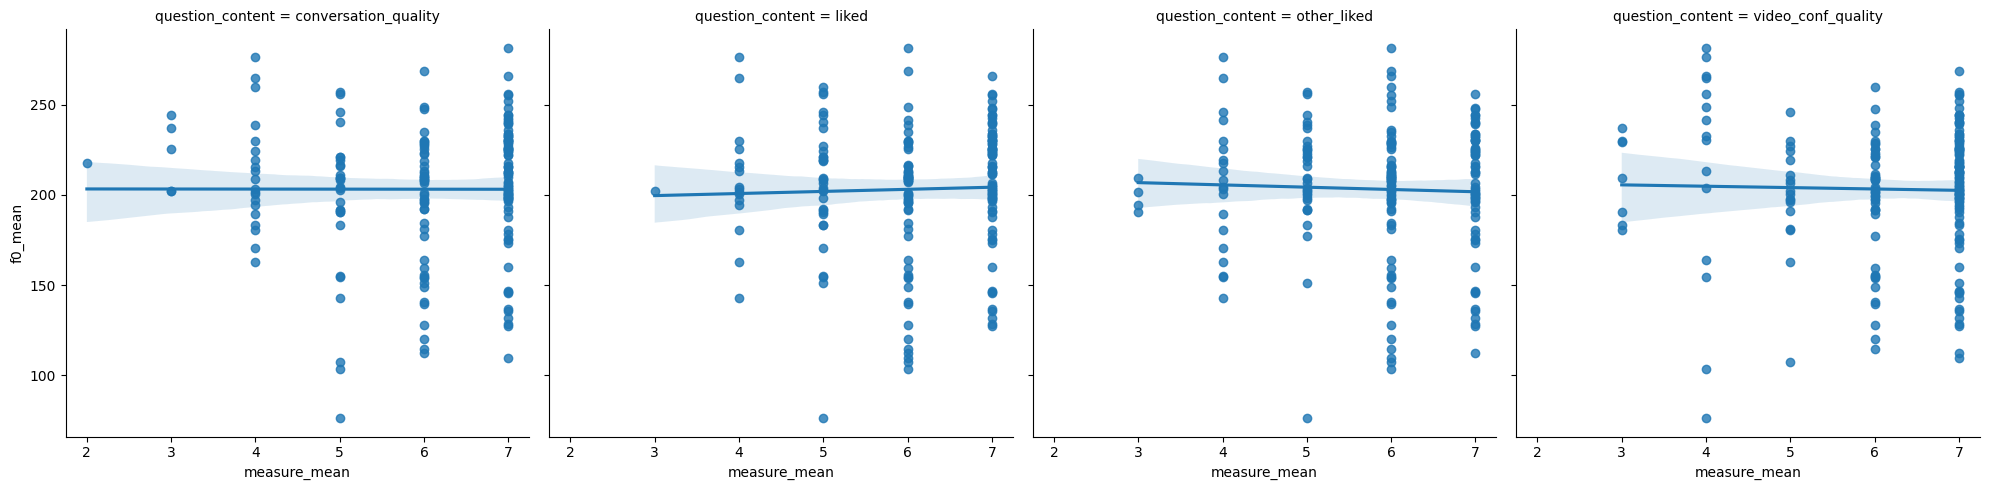

In [25]:
sns.lmplot(x="measure_mean", y="f0_mean", col="question_content", data=df_analysis)

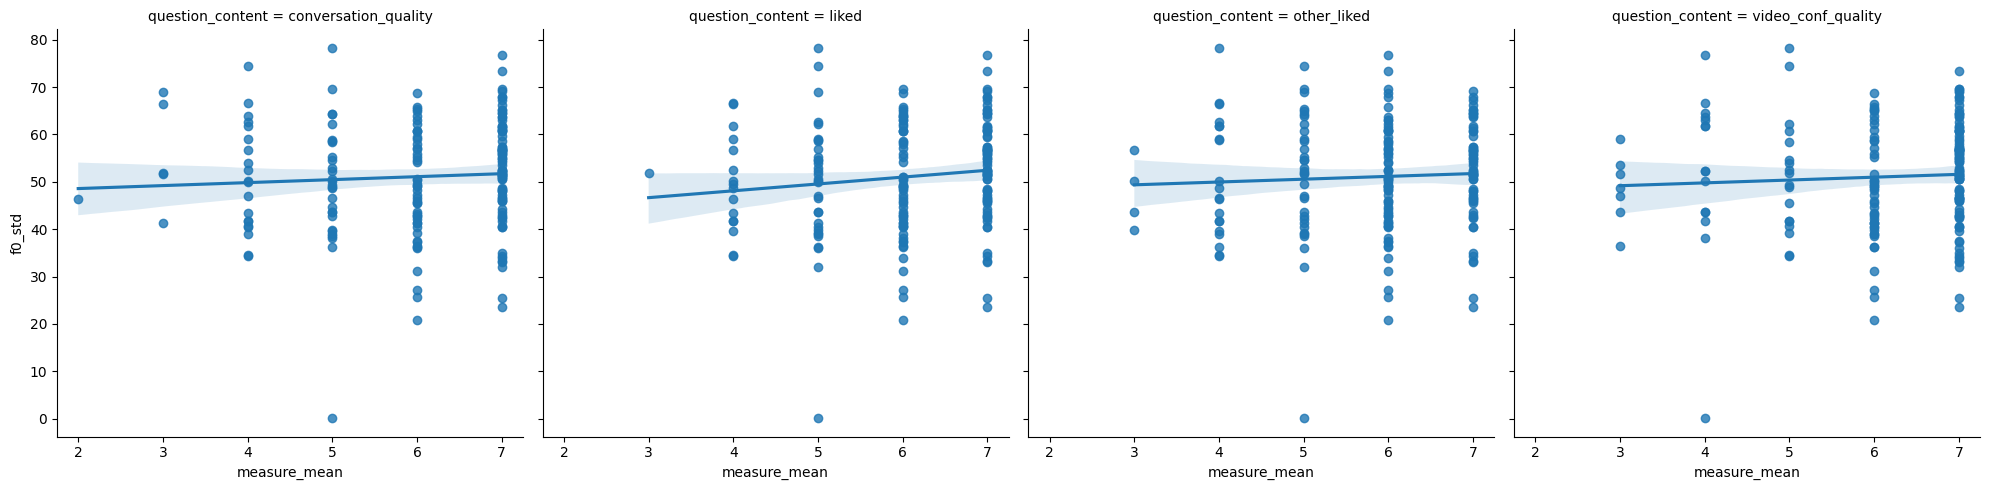

In [26]:
sns.lmplot(x="measure_mean", y="f0_std", col="question_content", data=df_analysis)